<a href="https://colab.research.google.com/github/s528661/nlp100/blob/main/nlp100_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第8章: ニューラルネット
第6章で取り組んだニュース記事のカテゴリ分類を題材として，ニューラルネットワークでカテゴリ分類モデルを実装する．なお，この章ではPyTorch, TensorFlow, Chainerなどの機械学習プラットフォームを活用せよ．

In [1]:
!pip install mecab-python3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.7/581.7 kB 8.0 MB/s eta 0:00:00


In [2]:
import gc
import re,sys,os

import pickle
import time
import copy

import math
import random
import string

from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import scipy as scp

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader, TensorDataset

from sklearn import feature_extraction, preprocessing

from sklearn import svm
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, f1_score
from sklearn.metrics import accuracy_score,  precision_score, recall_score, confusion_matrix, roc_auc_score

# import dask.array as da

import lightgbm as lgb

# Neural Language Processing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import SelectKBest

from sklearn.linear_model import RidgeClassifier
import MeCab

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# 70. 単語ベクトルの和による特徴量

In [3]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip --no-check-certificate
!unzip ./NewsAggregatorDataset.zip

--2023-11-17 13:44:26--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas     [  <=>               ]  27.87M  71.3MB/s    in 0.4s    

2023-11-17 13:44:26 (71.3 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203]

Archive:  ./NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [4]:
data = pd.read_csv('newsCorpora.csv',delimiter='\t',header=None,
                 names=["ID", "TITLE", "URL", "PUBLISHER", "CATEGORY", "STORY", "HOSTNAME", "TIMESTAMP"])

In [5]:
data

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027
...,...,...,...,...,...,...,...,...
422414,422933,Surgeons to remove 4-year-old's rib to rebuild...,http://www.cbs3springfield.com/story/26378648/...,WSHM-TV,m,dpcLMoJD69UYMXMxaoEFnWql9YjQM,www.cbs3springfield.com,1409229190251
422415,422934,Boy to have surgery on esophagus after battery...,http://www.wlwt.com/news/boy-to-have-surgery-o...,WLWT Cincinnati,m,dpcLMoJD69UYMXMxaoEFnWql9YjQM,www.wlwt.com,1409229190508
422416,422935,Child who swallowed battery to have reconstruc...,http://www.newsnet5.com/news/local-news/child-...,NewsNet5.com,m,dpcLMoJD69UYMXMxaoEFnWql9YjQM,www.newsnet5.com,1409229190771
422417,422936,Phoenix boy undergoes surgery to repair throat...,http://www.wfsb.com/story/26368078/phoenix-boy...,WFSB,m,dpcLMoJD69UYMXMxaoEFnWql9YjQM,www.wfsb.com,1409229191071


In [6]:
fix_data = data[data['PUBLISHER'].isin(["Reuters", "Huffington Post", "Businessweek", "Contactmusic.com", "Daily Mail"])]

In [7]:
def preprocessing(text):
  text = "".join([i for i in text if i not in string.punctuation])
  text = text.lower()
  text = re.sub("[0-9]+", "", text)
  return text

In [8]:
fix_data['pTITLE'] = fix_data['TITLE'].apply(lambda x: preprocessing(x))

<ipython-input-8-0330034268ea>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fix_data['pTITLE'] = fix_data['TITLE'].apply(lambda x: preprocessing(x))


In [9]:
vectorizer = TfidfVectorizer(min_df=10, ngram_range=(1, 2)) # 1-gram, 2-gramでTfidfを計算
X = vectorizer.fit_transform(fix_data['pTITLE']).toarray()
X = pd.DataFrame(X, columns=vectorizer.get_feature_names_out())

In [10]:
X_train_all, X_test = train_test_split(X, test_size=0.2, shuffle=True)

In [11]:
X_train, X_val = train_test_split(X_train_all, test_size=0.1, shuffle=True)

In [12]:
y_train = fix_data.iloc[X_train.index]['CATEGORY'].map({'b': 0, 'e': 1, 't': 2, 'm': 3})
y_val = fix_data.iloc[X_val.index]['CATEGORY'].map({'b': 0, 'e': 1, 't': 2, 'm': 3})
y_test = fix_data.iloc[X_test.index]['CATEGORY'].map({'b': 0, 'e': 1, 't': 2, 'm': 3})

In [13]:
!rm -rf data
!mkdir data

!mkdir data/train
!mkdir data/val
!mkdir data/test

In [14]:
X_train.to_pickle('data/train/X_train.pkl')
X_val.to_pickle('data/val/X_val.pkl')
X_test.to_pickle('data/test/X_test.pkl')

In [15]:
y_train.to_pickle('data/train/y_train.pkl')
y_val.to_pickle('data/val/y_val.pkl')
y_test.to_pickle('data/test/y_test.pkl')

# 71. 単層ニューラルネットワークによる予測

In [16]:
class Net(nn.Module):
  def __init__(self,n_input,n_hidden,n_output):
    super(Net,self).__init__()
    self.input = nn.Linear(n_input,n_hidden,bias=True)
    self.hidden = nn.Linear(n_hidden,n_hidden,bias=True)
    self.output = nn.Linear(n_hidden,n_output,bias=False)

  def forward(self, x):
    x = self.input(x)
    x = F.relu(x)
    x = self.hidden(x)
    x = F.relu(x)
    x = self.output(x)
    x = F.softmax(x)
    return x

In [17]:
X_train = pd.read_pickle('data/train/X_train.pkl')
X_val = pd.read_pickle('data/val/X_val.pkl')
X_test = pd.read_pickle('data/test/X_test.pkl')

In [18]:
y_train = pd.read_pickle('data/train/y_train.pkl')
y_val = pd.read_pickle('data/val/y_val.pkl')
y_test = pd.read_pickle('data/test/y_test.pkl')

In [19]:
tensor_X_train = torch.tensor(X_train.values.astype('float32'))
tensor_X_val = torch.tensor(X_val.values.astype('float32'))
tensor_X_test = torch.tensor(X_test.values.astype('float32'))

tensor_y_train = torch.tensor(y_train.values.astype('float32'),dtype=torch.long)
tensor_y_val = torch.tensor(y_val.values.astype('float32'),dtype=torch.long)
tensor_y_test = torch.tensor(y_test.values.astype('float32'),dtype=torch.long)

In [20]:
n_input = X_train.shape[1]
n_hidden = 32
n_output = 4

In [21]:
model = Net(n_input,n_hidden,n_output)

In [22]:
y_train_pred = model(tensor_X_train)

<ipython-input-16-b1e20c28f337>:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


In [23]:
y_train_pred

tensor([[0.2420, 0.2564, 0.2603, 0.2413],
        [0.2411, 0.2560, 0.2614, 0.2415],
        [0.2421, 0.2562, 0.2613, 0.2404],
        ...,
        [0.2426, 0.2561, 0.2606, 0.2407],
        [0.2414, 0.2552, 0.2623, 0.2412],
        [0.2416, 0.2561, 0.2615, 0.2408]], grad_fn=<SoftmaxBackward0>)

# 72. 損失と勾配の計算

In [24]:
loss_fn = nn.CrossEntropyLoss()

In [25]:
loss_fn(y_train_pred,tensor_y_train)

tensor(1.3867, grad_fn=<NllLossBackward0>)

# 73. 確率的勾配降下法による学習

確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，行列W
を学習せよ．なお，学習は適当な基準で終了させればよい（例えば「100エポックで終了」など）．

In [26]:
optimizer = optim.SGD(model.parameters(),lr=0.001)

In [27]:
train_dataset = torch.utils.data.TensorDataset(tensor_X_train, tensor_y_train)

In [28]:
epochs = 50
for epoch in range(epochs):
  for x, y in train_dataset:
    optimizer.zero_grad()
    y_x_pred = model(x)
    loss = loss_fn(y_x_pred,y)
    loss.backward()
    optimizer.step()

<ipython-input-16-b1e20c28f337>:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


# 74. 正解率の計測

問題73で求めた行列を用いて学習データおよび評価データの事例を分類したとき，その正解率をそれぞれ求めよ．

In [29]:
y_train_pred = model(tensor_X_train)

<ipython-input-16-b1e20c28f337>:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


In [30]:
y_val_pred = model(tensor_X_val)

<ipython-input-16-b1e20c28f337>:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


In [31]:
y_train_pred = np.argmax(y_train_pred.detach().numpy(),1)
y_val_pred = np.argmax(y_val_pred.detach().numpy(),1)

In [32]:
print(f'Train Accuracy: {accuracy_score(tensor_y_train.detach().numpy(), y_train_pred)}')
print(f'Valid Accuracy: {accuracy_score(tensor_y_val.detach().numpy(), y_val_pred)}')

Train Accuracy: 0.8120574760516451
Valid Accuracy: 0.7874531835205992


# 75. 損失と正解率のプロット

問題73のコードを改変し，各エポックのパラメータ更新が完了するたびに，訓練データでの損失，正解率，検証データでの損失，正解率をグラフにプロットし，学習の進捗状況を確認できるようにせよ．

# 76. チェックポイント

問題75のコードを改変し，各エポックのパラメータ更新が完了するたびに，チェックポイント（学習途中のパラメータ（重み行列など）の値や最適化アルゴリズムの内部状態）をファイルに書き出せ．

# 77. ミニバッチ化

問題76のコードを改変し，B
事例ごとに損失・勾配を計算し，行列Wの値を更新せよ（ミニバッチ化）．Bの値を1,2,4,8,…と変化させながら，1エポックの学習に要する時間を比較せよ．

# 78. GPU上での学習

問題77のコードを改変し，GPU上で学習を実行せよ．

In [47]:
train_dataset = torch.utils.data.TensorDataset(tensor_X_train, tensor_y_train)
#test_dataset = torch.utils.data.TensorDataset(tensor_X_test, tensor_y_test)

In [50]:
!rm -rf checkpoints
!mkdir checkpoints

In [51]:
epochs = 30

train_losses = []
train_accs = []
test_losses = []
test_accs = []
for epoch in range(epochs):
  for x, y in train_dataset:
    optimizer.zero_grad()
    y_train_pred0 = model(x)
    loss = loss_fn(y_train_pred0,y)
    loss.backward()
    optimizer.step()

  y_train_pred = model(tensor_X_train)
  train_loss = loss_fn(y_train_pred,tensor_y_train)
  y_train_pred = np.argmax(y_train_pred.detach().numpy(),1)
  score = accuracy_score(tensor_y_train,y_train_pred)

  train_losses.append(train_loss.detach().numpy())
  train_accs.append(score)

  with torch.no_grad():
    y_test_pred = model(tensor_X_test)
    tloss = loss_fn(y_test_pred,tensor_y_test)

    y_test_pred = np.argmax(y_test_pred.detach().numpy(),1)
    tscore = accuracy_score(tensor_y_test.detach().numpy(), y_test_pred)

    test_losses.append(tloss.detach().numpy())
    test_accs.append(tscore)

  torch.save(model.state_dict(), 'checkpoints/'+str(epoch)+'.model')
  torch.save(optimizer.state_dict(), 'checkpoints/'+str(epoch)+'.param')

<ipython-input-16-b1e20c28f337>:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)
<ipython-input-16-b1e20c28f337>:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)
<ipython-input-16-b1e20c28f337>:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)
<ipython-input-16-b1e20c28f337>:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)
<ipython-input-16-b1e20c28f337>:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)
<ipython-input-16-b1e20c28f337>:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the c

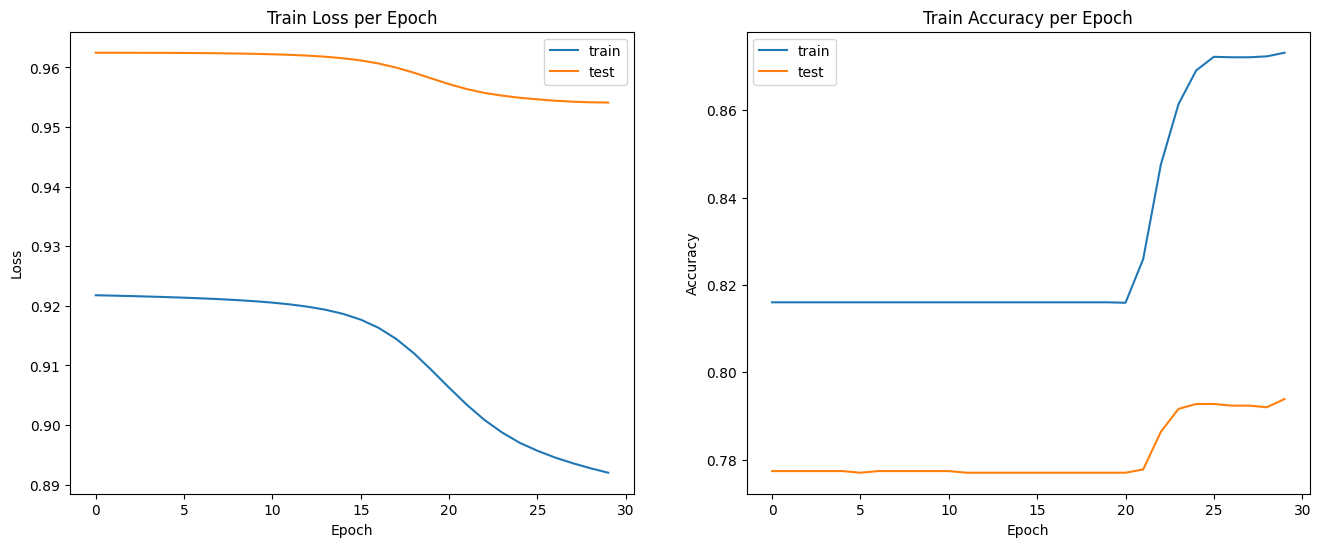

In [52]:
fig, ax = plt.subplots(1,2,figsize=(16, 6))

ax_epochs = np.arange(epochs)

ax[0].plot(ax_epochs,train_losses,label="train")
ax[0].plot(ax_epochs,test_losses,label="test")
ax[0].set_title("Train Loss per Epoch")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(ax_epochs,train_accs,label="train")
ax[1].plot(ax_epochs,test_accs,label="test")
ax[1].set_title("Train Accuracy per Epoch")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()

# 79. 多層ニューラルネットワーク

問題78のコードを改変し，バイアス項の導入や多層化など，ニューラルネットワークの形状を変更しながら，高性能なカテゴリ分類器を構築せよ．